<a href="https://colab.research.google.com/github/Sky0307/2022DLProject/blob/main/build_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# this notebook is to build our own custom dataset

In [1]:
import numpy as np
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import os
import h5py
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = "drive/MyDrive/datasets/sample_music/"
genre_path_dict = dict()
label_dict = dict()

for (dirpath, dirnames, filenames) in os.walk(data_path):
    if dirnames:
        for idx, genre in enumerate(dirnames):
            genre_path_dict[genre] = list()
            label_dict[genre] = idx
        continue
    else:
        genre = dirpath.split('/')[-1]
        for au_file in filenames:
            if 'mp3' in au_file:
                current_path = dirpath + '/' + au_file
                genre_path_dict[genre].append(current_path)

total_file = sum([len(genre_path_dict[genre]) for genre in genre_path_dict])
total_file

23

## params

In [5]:
# global varibles:
sr = 16000
cut_time = 10  # throw first and last 10s
cut_wave_length = cut_time * sr
n_ftt = 512
hop = n_ftt // 4

In [6]:
label_dict

{'blues': 5,
 'classical': 7,
 'country': 9,
 'disco': 1,
 'hiphop': 8,
 'jazz': 3,
 'metal': 4,
 'pop': 6,
 'reggae': 0,
 'rock': 2}

In [7]:
genre_dict = dict()
for key in label_dict:
    genre_dict[label_dict.get(key)] = key

In [8]:
print(genre_path_dict['pop'][0])
genre_dict

drive/MyDrive/datasets/sample_music/pop/Panic! At The Disco - High Hopes (Official Video).mp3


{0: 'reggae',
 1: 'disco',
 2: 'rock',
 3: 'jazz',
 4: 'metal',
 5: 'blues',
 6: 'pop',
 7: 'classical',
 8: 'hiphop',
 9: 'country'}

In [9]:
def frame_feature_extractor(file_path):
    signal, _ = librosa.load(file_path, sr=sr)
    signal = signal[cut_wave_length: -1 * cut_wave_length] # cut wave length
    
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=256).T
    S = librosa.power_to_db(S)
    if not S.shape[0] % 256 == 0:
        S = S[:-1 * (S.shape[0] % 256)] # divide the mel spectrogram
    chunk_num = int(S.shape[0] / 256)
    mel_chunks = np.split(S, chunk_num) # create 128 * 128 data frames
    return mel_chunks, chunk_num

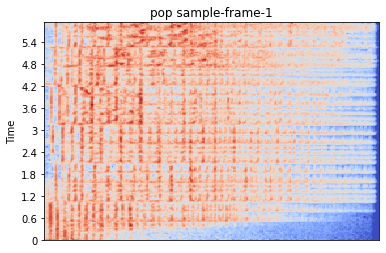

In [10]:
signal, chunk_num = frame_feature_extractor(genre_path_dict['pop'][0])
plt.title('pop sample-frame-1')
display.specshow(signal[0], y_axis='time')
plt.show()

# Build Dataset

In [23]:
def build_tag(genre):
    target = np.zeros(len(label_dict), dtype=int)
    pos = label_dict.get(genre)
    target[pos] = 1
    return target

build_tag('pop').shape

(10,)

In [31]:
data_path = "drive/MyDrive/datasets/own_data/"

In [38]:
count = 0
file_index = 0
mel_shape = signal[0].shape

for key in label_dict:
    print('deal with {0}'.format(key))
    for file_i, file in enumerate(genre_path_dict.get(key)):
        mel_list, chunk_number = frame_feature_extractor(file)
        dataset_name = data_path + str(file_index) + '.h5'
        current_dataset = h5py.File(dataset_name, 'a')
        
        current_dataset.create_dataset('mel', shape=(chunk_number, mel_shape[0], mel_shape[1]), dtype=np.float32)
        current_dataset.create_dataset('tag', shape=(chunk_number, 10 ), dtype=int)   
        
        for i, mel_signal_chunk in enumerate(mel_list):
            current_dataset['tag'][i] = build_tag(key)
            current_dataset['mel'][i] = mel_signal_chunk
            count += 1
        
        print('->{0}'.format(file_i), end='')
        current_dataset.close()
        file_index += 1
        
    print(' ')

print(count)
print(file_index)

deal with reggae
->0->1 
deal with disco
->0->1->2 
deal with rock
->0->1 
deal with jazz
->0->1->2 
deal with metal
->0->1 
deal with blues
->0->1 
deal with pop
->0->1 
deal with classical
->0->1->2 
deal with hiphop
->0->1 
deal with country
->0->1 
693
23


In [43]:
all_setpath = data_path + 'hand_all.h5'
all_dataset = h5py.File(all_setpath, 'a')

all_dataset.create_dataset('mel', shape=(count, mel_shape[0], mel_shape[1]), dtype=np.float32)
all_dataset.create_dataset('tag', shape=(count, 10 ), dtype=int)

<HDF5 dataset "tag": shape (693, 10), type "<i8">

# load data into one set

In [44]:
count = 0
for (dirpath, dirnames, filenames) in os.walk(data_path):
    if filenames:
        for set_name in filenames:
            if 'h5' not in set_name or 'all' in set_name:
                continue
            set_path = data_path + set_name
            tmp_dataset = h5py.File(set_path, 'r')
            tmp_count = tmp_dataset['mel'].shape[0]
            for i in range(tmp_count):
                all_dataset['mel'][count] = tmp_dataset['mel'][i]
                all_dataset['tag'][count] = tmp_dataset['tag'][i]
                count += 1
            tmp_dataset.close()
all_dataset.close()
print(count)

693


In [45]:
setpath1 = data_path + 'hand_all.h5'
setpath2 = 'drive/MyDrive/datasets/processed_GTZAN/all_long.h5'
db1 = h5py.File(setpath1, 'r')
db2 = h5py.File(setpath2, 'r')
all_chunk = count + 2997 # due to jazz.054 being corrupted

fin_setpath = data_path + 'fin_all.h5'
dataset = h5py.File(fin_setpath, 'a')
dataset.create_dataset('mel', shape=(all_chunk, mel_shape[0], mel_shape[1]), dtype=np.float32)
dataset.create_dataset('tag', shape=(all_chunk, 10 ), dtype=int) 

fin_count = 0
for j in range(count):
    dataset['mel'][fin_count] = db1['mel'][j]
    dataset['tag'][fin_count] = db1['tag'][j]
    fin_count += 1

db1.close()

for j in range(2996):
    print("j: {}".format(j))
    print("fin_count: {}".format(fin_count))
    dataset['mel'][fin_count] = db2['mel'][j]
    dataset['tag'][fin_count] = db2['tag'][j]
    fin_count += 1

db2.close()
dataset.close()
print(fin_count)

Streaming output truncated to the last 5000 lines.
fin_count: 1189
j: 497
fin_count: 1190
j: 498
fin_count: 1191
j: 499
fin_count: 1192
j: 500
fin_count: 1193
j: 501
fin_count: 1194
j: 502
fin_count: 1195
j: 503
fin_count: 1196
j: 504
fin_count: 1197
j: 505
fin_count: 1198
j: 506
fin_count: 1199
j: 507
fin_count: 1200
j: 508
fin_count: 1201
j: 509
fin_count: 1202
j: 510
fin_count: 1203
j: 511
fin_count: 1204
j: 512
fin_count: 1205
j: 513
fin_count: 1206
j: 514
fin_count: 1207
j: 515
fin_count: 1208
j: 516
fin_count: 1209
j: 517
fin_count: 1210
j: 518
fin_count: 1211
j: 519
fin_count: 1212
j: 520
fin_count: 1213
j: 521
fin_count: 1214
j: 522
fin_count: 1215
j: 523
fin_count: 1216
j: 524
fin_count: 1217
j: 525
fin_count: 1218
j: 526
fin_count: 1219
j: 527
fin_count: 1220
j: 528
fin_count: 1221
j: 529
fin_count: 1222
j: 530
fin_count: 1223
j: 531
fin_count: 1224
j: 532
fin_count: 1225
j: 533
fin_count: 1226
j: 534
fin_count: 1227
j: 535
fin_count: 1228
j: 536
fin_count: 1229
j: 537
fin_co

# build separate dataset

In [50]:
import random

In [51]:
directory = "drive/MyDrive/datasets"

dataset = h5py.File(fin_setpath, 'r')
train_file = fin_count * 0.8
valid_file = fin_count * 0.1
test_file = fin_count - int(train_file) - int(valid_file)
train_set = directory + '/own_datasets/l_train.h5'
valid_set = directory + '/own_datasets/l_valid.h5'
test_set = directory + '/own_datasets/l_test.h5'
files = [int(a) for a in [train_file, valid_file, test_file]]
sets = [train_set, valid_set, test_set]
print(files)

[2951, 368, 370]


# shuffle and create

In [52]:
idx = [i for i in range(fin_count)]
random.seed(516)
random.shuffle(idx)
train_idx = idx[:files[0]]
valid_idx = idx[files[0]: files[0]+files[1]]
test_idx = idx[-files[2]:]
indices = [train_idx, valid_idx, test_idx]

# copy

In [53]:
for i, dset in enumerate(sets):
    s_set = h5py.File(dset, 'a')
    indice = indices[i]
    file_num = files[i]
    
    s_set.create_dataset('mel', shape=(file_num, mel_shape[0], mel_shape[1]), dtype=np.float32)
#     s_set.create_dataset('mfcc', shape=(file_num, mfcc_shape[0], mfcc_shape[1]), dtype=np.float32)
    s_set.create_dataset('tag', shape=(file_num, 10 ), dtype=int)
    
    count = 0
    for i in indice:
        s_set['mel'][count] = dataset['mel'][i]
#         s_set['mfcc'][count] = dataset['mfcc'][i]
        s_set['tag'][count] = dataset['tag'][i]
        count += 1
        
        if count % 10 == 0:
            print('*', end="")
    
    s_set.close()
    print()  
    print('Create Separate Datasets {0}'.format(dset))

*******************************************************************************************************************************************************************************************************************************************************************************************************
Create Separate Datasets drive/MyDrive/datasets/own_datasets/l_train.h5
************************************
Create Separate Datasets drive/MyDrive/datasets/own_datasets/l_valid.h5
*************************************
Create Separate Datasets drive/MyDrive/datasets/own_datasets/l_test.h5


In [54]:
t_set = h5py.File(train_set, 'r')
mel_shape
(256, 256)
print(t_set['mel'].shape)
print(t_set['tag'][:5])

(2951, 256, 256)
[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]]
